# Multilingual Sentiment Analysis

### Motivation
In today's world as models are becoming larger and larger, and more languages are become relevant in digital media we need ability to scale models across multiple languages

#### Data

The data set I am using for this sentiment analysis is book reviews on Amazon.
* The book reviews are available in three languages - english, french & german
* The data is not a lot for deep learning tasks, however we will see the power of pretrained models to help in performance
* The books are rated from 1 to 5, 5 being the higest positive rating and 1 being the lowest negative rating, we have modified this to negative rating of 0 if review < 3 and positive rating of 1

In [1]:
import utils

raw_data = utils.get_data()
raw_data.sample(20)

,id,summary,rating,text,category,sentiment,language
1184,1185,Décevant.,2.0,Avec Jonathan Kellerman ça ne passe décidément...,Livres,negative,french
1802,1803,Reviewer,2.0,I am interested in succint yet exhaustive/subs...,books,negative,english
796,797,a long book that seems to get longer as you re...,2.0,The relationships between the various characte...,books,negative,english
1495,1496,Not Technical Enough,2.0,This book is heavy on jargon and vendor provid...,books,negative,english
1475,1476,voodoo,1.0,leider geht es mir da wie schon meinen leidens...,Bücher,negative,german
1485,1486,Incontournable et bouleversant.,5.0,Ce très court roman de Stefan Zweig demeure un...,Livres,positive,french
1378,1379,Das Buch - auch nicht besser wie der Film,1.0,"Gleich vorweg, wem der Film gefallen hat, der ...",Bücher,negative,german
1695,1696,An Exciting and Thrilling Read,5.0,I give this outing of the Amelia Peabody Emers...,books,positive,english
1088,1089,A découvrir,5.0,On aurait pu s'attendre à de la propagande: c'...,Livres,positive,french
1773,1774,A delightful little book...,4.0,"I'm sorry to see that this delightful, albeit ...",books,positive,english


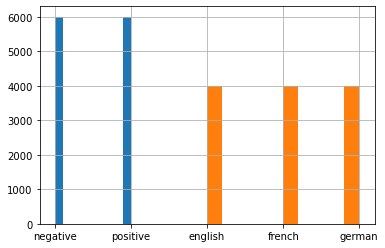

In [2]:
raw_data['sentiment'].hist()
raw_data['language'].hist()

### Normalize labels & split into training, validation & test dataset

For pre-processing I will:
* set negative sentiment to 0
* set positive sentiment to 1

For splitting data I will:
* Set aside 20% data for testing
* Use 20% of training 

In [3]:
from sklearn.model_selection import train_test_split

raw_data['label'] = utils.preprocess_labels(raw_data)

# test data
train_df, test_df = train_test_split(raw_data, test_size=0.2)

# training & validation data
train_df, val_df = train_test_split(raw_data, test_size = 0.2)

In [4]:
# lets create a data set class to help work with the above data set when using py-torch
from torch.utils.data import Dataset

class AmazonReviewDataset(Dataset):
    def __init__(self, df):
        self.label = list(df.label)
        self.text = list(df.summary + " " + df.text)
        self.language = list(df.language)
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):
        return self.text[index], self.label[index]

train_dataset = AmazonReviewDataset(train_df)
test_dataset = AmazonReviewDataset(test_df)
val_dataset = AmazonReviewDataset(val_df)

### Train a multilingual BERT Network

1. Tokenize using bert multilingual cased tokenizer
2. Use pretrained BERT model sequence classification model
3. Fine tune model
4. Stop using early stopping

In [5]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
import torch
import tqdm.notebook as tqdm

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")


# load pre-trained model & tokenizer
BERT_CONFIG = 'distilbert-base-multilingual-cased'
TEXT_MAX_LENGTH = 256
model = DistilBertForSequenceClassification.from_pretrained(BERT_CONFIG).to(device)
tokenizer = DistilBertTokenizer.from_pretrained(BERT_CONFIG)


# create optimizer and loss fn
LEARNING_RATE = 3e-5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = CrossEntropyLoss()

Running on the GPU


In [6]:
EPOCHS = 15
BATCH_SIZE = 64

# create data sets for 
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# early stopping
patience = 3
improved = 0
prev_loss = 10
not_improved = 0
history=[]
history_loss=[]
historyval=[]
hitoryval_loss=[]

for epoch in range(EPOCHS):
    # training step
    running_loss = 0.0
    batch_count = 0
    correct_preds = 0
    total_preds = 0
    
    model.train()
    
    for texts, labels in tqdm.tqdm(train_dataloader, desc="Training", leave=False):
        tokens = tokenizer.batch_encode_plus(texts,
                                             return_tensors='pt',
                                             max_length=TEXT_MAX_LENGTH,
                                             pad_to_max_length=True)
        labels = labels.unsqueeze(1)

        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
        
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        # run model, calc/apply gradients
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs[:2]
        loss.backward()
        optimizer.step()
        
        # calculate metrics
        preds = torch.argmax(logits,1).unsqueeze(1)
        correct_preds += (labels == preds).sum()
        total_preds += len(labels)
        running_loss +=  loss.item()
        batch_count += 1
    
    result = f'Epoch: {epoch+1} Training loss: {round(running_loss/batch_count,5)} accuracy: {correct_preds*100/total_preds}%'
    history.append(correct_preds*100/total_preds)
    history_loss.append(running_loss/batch_count)
    
    
    # validation step
    running_loss = 0.0
    batch_count = 0
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        model.eval()
        
        for texts, labels in tqdm.tqdm(train_dataloader, desc="Validating", leave=False):
            tokens = tokenizer.batch_encode_plus(texts,
                                                 return_tensors='pt',
                                                 max_length=TEXT_MAX_LENGTH,
                                                 pad_to_max_length=True)
            labels = labels.unsqueeze(1)

            input_ids = tokens['input_ids']
            attention_mask = tokens['attention_mask']
        
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            

            # run model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss, logits = outputs[:2]
            
            # calculate metrics
            preds = torch.argmax(logits,1).unsqueeze(1)
            correct_preds += (labels == preds).sum()
            total_preds += len(labels)
            running_loss +=  loss.item()
            batch_count += 1

    result_val = f'Validation loss: {round(running_loss/batch_count,5)} accuracy: {correct_preds*100/total_preds}%'
    historyval.append(correct_preds*100/total_preds)
    hitoryval_loss.append(running_loss/batch_count)
    print(result+' '+result_val)

    if(running_loss<prev_loss):
        not_improved=0

    if(prev_loss<running_loss):
        not_improved+=1

    if(not_improved==patience):
        break
        
    prev_loss = running_loss

Epoch: 1 Training loss: 0.46438 accuracy: 76% Validation loss: 0.22307 accuracy: 91%


Epoch: 2 Training loss: 0.25236 accuracy: 89% Validation loss: 0.10847 accuracy: 96%


Epoch: 3 Training loss: 0.15182 accuracy: 94% Validation loss: 0.05416 accuracy: 98%


Epoch: 4 Training loss: 0.08059 accuracy: 97% Validation loss: 0.04802 accuracy: 98%


Epoch: 5 Training loss: 0.07451 accuracy: 97% Validation loss: 0.05806 accuracy: 97%


Epoch: 6 Training loss: 0.05046 accuracy: 98% Validation loss: 0.01717 accuracy: 99%


Epoch: 7 Training loss: 0.03038 accuracy: 98% Validation loss: 0.0075 accuracy: 99%


Epoch: 8 Training loss: 0.02254 accuracy: 99% Validation loss: 0.00654 accuracy: 99%


Epoch: 9 Training loss: 0.01984 accuracy: 99% Validation loss: 0.00395 accuracy: 99%


Epoch: 10 Training loss: 0.01105 accuracy: 99% Validation loss: 0.00362 accuracy: 99%


Epoch: 11 Training loss: 0.01501 accuracy: 99% Validation loss: 0.00273 accuracy: 99%


Epoch: 12 Training loss: 0.01496 accuracy: 99% Validation loss: 0.00557 accuracy: 99%


Epoch: 13 Training loss: 0.01642 accuracy: 99% Validation loss: 0.00411 accuracy: 99%


Epoch: 14 Training loss: 0.01649 accuracy: 99% Validation loss: 0.00199 accuracy: 99%


Epoch: 15 Training loss: 0.01018 accuracy: 99% Validation loss: 0.00142 accuracy: 99%


In [7]:
# run on test dataset

running_loss = 0.0
batch_count = 0
correct_preds = 0
total_preds = 0


test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Y=None
Y_PRED=None
with torch.no_grad():
    model.eval()

    for texts, labels in tqdm.tqdm(test_dataloader, desc="Testing", leave=False):
        tokens = tokenizer.batch_encode_plus(texts,
                                             return_tensors='pt',
                                             max_length=TEXT_MAX_LENGTH,
                                             pad_to_max_length=True)
        labels = labels.unsqueeze(1)
        
        if(Y is None):
            Y = labels
        else:
            Y = torch.cat((Y, labels))
        
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)


        # run model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs[:2]

        # calculate metrics
        preds = torch.argmax(logits,1).unsqueeze(1)
        correct_preds += (labels == preds).sum()
        total_preds += len(labels)
        running_loss +=  loss.item()
        batch_count += 1
        
        
        if(Y_PRED is None):
            Y_PRED = preds
        else:
            Y_PRED = torch.cat((Y_PRED, preds))

print(f'Test loss: {round(running_loss/batch_count,5)} accuracy: {correct_preds*100/total_preds}%')

Test loss: 0.13058 accuracy: 97%


In [8]:
from sklearn.metrics import classification_report
print(classification_report(Y.cpu(), Y_PRED.cpu(),target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.98      0.98      0.98      1242
    Positive       0.98      0.97      0.97      1158

    accuracy                           0.98      2400
   macro avg       0.98      0.98      0.98      2400
weighted avg       0.98      0.98      0.98      2400



### Investigate hidden layer output of same text translated in different languages

1. Get hidden layer output of the first token which is essentially the representation of the sentence
2. Get output of same sentence in multiple languages
3. Plot hidden layer output into 2D scatter plot using PCA

In [16]:
samples = [["Please don't read this book!! I hate how the author has  portrayed the characters"],
["S’il vous plaît ne lisez pas ce livre! Je déteste la façon dont l’auteur a dépeint les personnages"],
["Bitte lesen Sie dieses Buch nicht!! Ich hasse es, wie der Autor die Charaktere porträtiert hat"],
["I loved this book, its one of those books that people are going to enjoy"],
["J’ai adoré ce livre, c’est un de ces livres que les gens vont apprécier"],
["Ich liebte dieses Buch, eines dieser Bücher, die die Menschen genießen werden"],
["Such a crappy story, the first few chapters are cool but the remainder of the book is pretty boring"],
["Une telle histoire merdique, les premiers chapitres sont cool, mais le reste du livre est assez ennuyeux"],
["So eine beschissene Geschichte, die ersten Kapitel sind cool, aber der Rest des Buches ist ziemlich langweilig"],
["JK Rowling has really written one of her worst books. The story is about a young wizard named harry potter. It's about magic and all, definitely not meant for adults"],
["JK Rowling a vraiment écrit de ses pires livres. L’histoire raconte l’histoire d’un jeune sorcier nommé harry potier. Il s’agit de magie et tout, certainement pas destiné aux adultes"],
["JK Rowling hat wirklich von ihren schlimmsten Büchern geschrieben. Die Geschichte handelt von einem jungen Zauberer namens harry potter. Es geht um Magie und alles, definitiv nicht für Erwachsene gedacht"],
["Hands down the best novel I have read so far in my life, the characters are very well written, there is a lot of depth"],
["De loin le meilleur roman que j'ai lu jusqu'à présent dans ma vie, les personnages sont très bien écrits, il y a beaucoup de profondeur"],
["Zweifellos der beste Roman, den ich bisher in meinem Leben gelesen habe, die Charaktere sind sehr gut geschrieben, es gibt viel Tiefe"],
]

In [17]:
local_model = model.cpu()

In [18]:
x=[]
import numpy as np

for s in samples:
    k = tokenizer.encode_plus(s[0], return_tensors='pt')
    k_inp = k['input_ids']
    k_mask = k['attention_mask']
    x.append(local_model.distilbert(k_inp, k_mask)[0][0][0].detach().numpy())

from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca_out = pca.fit_transform(x)

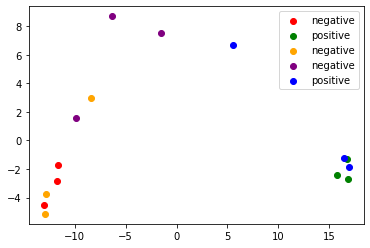

In [20]:
import matplotlib.pyplot as plt

pca_out = pca_out.reshape((5,3,2))

review_colors = ['red', 'green', 'orange', 'purple', 'blue']
review_type = ['negative', 'positive', 'negative', 'negative', 'positive']

for review in range(5):
    x = []
    y = []
    for language in range(3):
        x.append(pca_out[review][language][0])
        y.append(pca_out[review][language][1])
    
    plt.scatter(x, y, color=review_colors[review], label=review_type[review])
        
plt.legend()
plt.show()

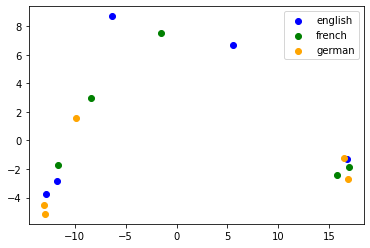

In [21]:
language_colors = ['blue', 'green', 'orange']
language_type = ['english', 'french', 'german']

for language in range(3):
    x = []
    y = []
    for review in range(5):
        x.append(pca_out[review][language][0])
        y.append(pca_out[review][language][1])    
    
    plt.scatter(x, y, color=language_colors[language], label=language_type[language])
        
plt.legend()
plt.show()